In [1]:
#from __future__ import print_function
#%matplotlib inline
#import argparse
#import os
#import random
import torch
import torch.nn as nn
#import torch.nn.parallel
#import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
# Root directory for dataset
dataroot = "dataset"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
#image_size = 64

# Number of channels in the training images. For color images this is 3 or 1 for black and white images
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
#num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

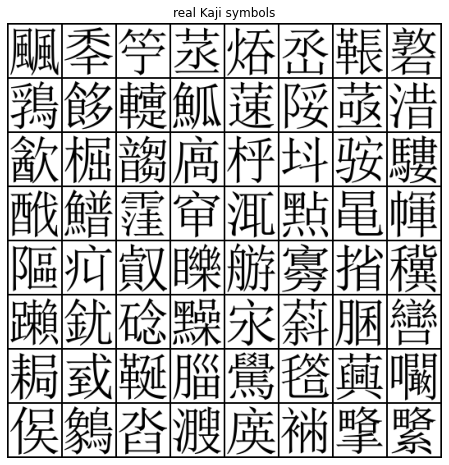

In [3]:
dataset = dset.ImageFolder(root=dataroot, transform=transforms.Compose([transforms.Grayscale(),
                                                                        transforms.ToTensor(),
                                                                       transforms.Normalize([0.5],[0.5])]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# show a sample
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('real Kaji symbols')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][0:64], padding=2, normalize=True),(1,2,0)))

In [4]:
# custom weight initialization
def weight_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0, 0.02)
    elif classname.find('BatchNorm')!=-1:
        nn.init.normal_(m.weight.data, 1, 0.02)
        nn.init.constant_(m.bias.data, 0)        

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, input):
        return self.main(input)

In [6]:
G = Generator()
G.apply(weight_init)
print(G)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

In [8]:
D = Discriminator()
D.apply(weight_init)
print(D)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [9]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(D.parameters(), lr = lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(G.parameters(), lr = lr, betas=(beta1, 0.999))

Stating Traning Loop...
1 of 3 epochs
            0th data batch of 52 batches
            Loss_D: 0.007158139254897833
            Loss_G: 5.220260143280029
            D(x): 0.9740021228790283
            D(G(z)): 0.011000209487974644/0.011844495311379433 ~ 0.9287191390422812


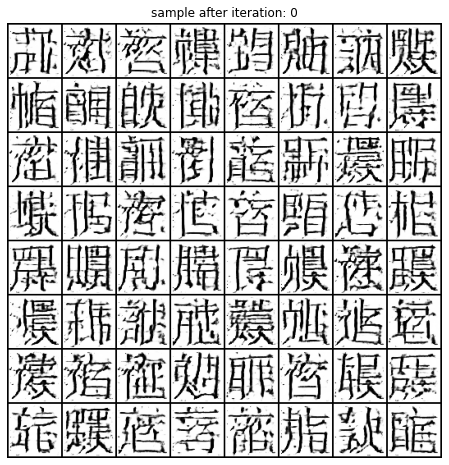

1 of 3 epochs
            50th data batch of 52 batches
            Loss_D: 0.06549591571092606
            Loss_G: 4.298932075500488
            D(x): 0.9670607447624207
            D(G(z)): 0.023990659043192863/0.006805566139519215 ~ 3.5251525811910933


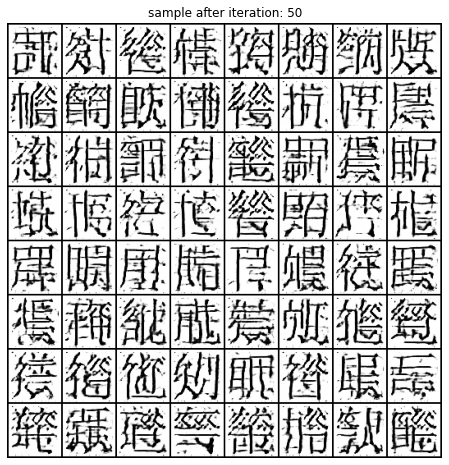

2 of 3 epochs
            0th data batch of 52 batches
            Loss_D: 0.141985222697258
            Loss_G: 8.174206733703613
            D(x): 0.9886226058006287
            D(G(z)): 0.000666486972477287/0.07209190726280212 ~ 0.00924496240677461


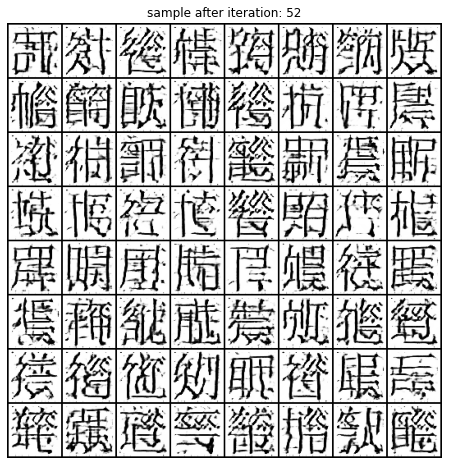

2 of 3 epochs
            50th data batch of 52 batches
            Loss_D: 0.17779715359210968
            Loss_G: 4.860109329223633
            D(x): 0.986188530921936
            D(G(z)): 0.015723800286650658/0.08141075074672699 ~ 0.1931415708911493


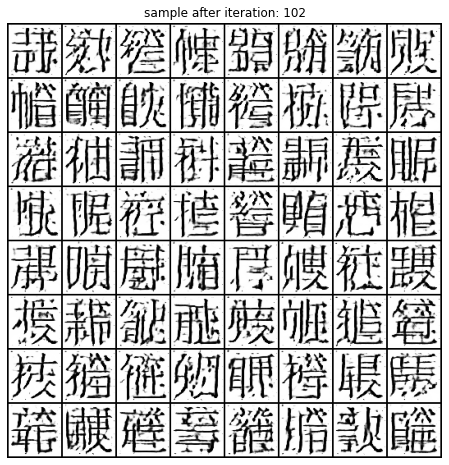

3 of 3 epochs
            0th data batch of 52 batches
            Loss_D: -0.004774592816829681
            Loss_G: 6.943696975708008
            D(x): 0.9795487523078918
            D(G(z)): 0.0025469353422522545/0.014098752290010452 ~ 0.1806496979209191


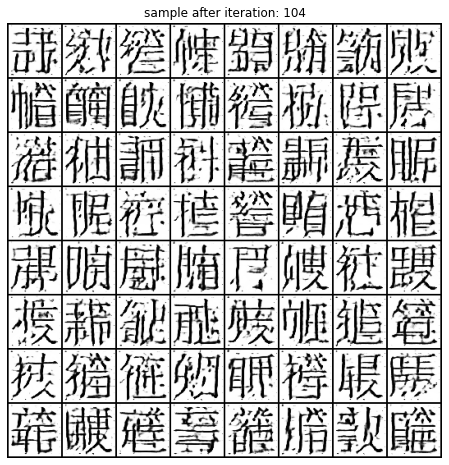

3 of 3 epochs
            50th data batch of 52 batches
            Loss_D: -0.01543587539345026
            Loss_G: 5.85545539855957
            D(x): 0.9763783812522888
            D(G(z)): 0.007221884094178677/0.0040443213656544685 ~ 1.7856850238235216


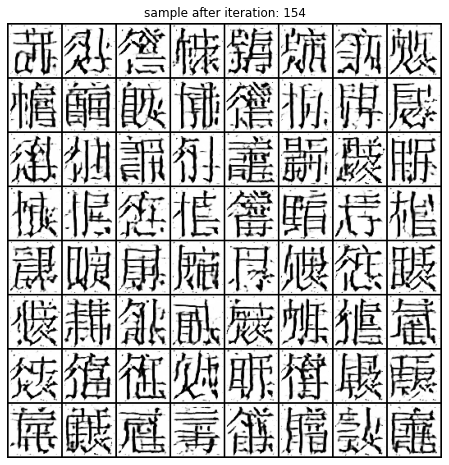

In [108]:
im_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 80

print('Stating Traning Loop...')
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Given a real image x and a normal sample z. We want to minimize the function the classification of error
        # of x and the classification error of G(z). That is we want to minimize
        # criterion(D(x), real_labels) + criterion(D(G(z)), fake_labels). It is suggested we add noise to the labels.
        D.zero_grad()
        label = torch.full((data[0].size(0),), real_label, dtype=torch.float)
        label += 0.1*torch.randn(label.size())
        output = D(data[0]).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()    # the mean of the real outputs. This should get close to 1/2 as G gets better
                                      # as when G gets better D can not differentiate between the outputs of G and the
                                      # real images.
        
        noise = torch.randn(data[0].size(0), nz, 1, 1)
        fake = G(noise)
        label.fill_(fake_label)
        label += 0.1*torch.randn(label.size()) # added noise to the labels
        output = D(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()  # This should converge to 1/2 for the same reasoning above.
        
        errD = errD_real + errD_fake
        optimizerD.step()
        
        
        
        # Given a normal sample z. The goal is maximize the error of D in classification of G(z), or we equivalently
        # would seek minimizing the error of disclassification of D for G(z). That is we want to minimize
        # criterion(D(G(z)), real_labels)
        G.zero_grad()
        label.fill_(real_label)
        label += 0.1*torch.randn(label.size()) # added noise to the labels
        output = D(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()   # This should converge to 1/2 for the same reasoning above.
        optimizerG.step()
        
        
        
        if i%50 == 0:
            print(f'''{epoch+1} of {num_epochs} epochs
            {i}th data batch of {len(dataloader)} batches
            Loss_D: {errD.item()}
            Loss_G: {errG.item()}
            D(x): {D_x}
            D(G(z)): {D_G_z2:%.4f} and {D_G_z1:%.4f}''')
            G_losses.append(errG.item())
            D_losses.append(errD.item())
            
            with torch.no_grad():
                fake = G(fixed_noise).detach()
            im_list.append(vutils.make_grid(fake, padding=2, nomalize=True))
            plt.figure(figsize=(8,8))
            plt.axis('off')
            plt.title(f'sample after iteration: {iters}')
            plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True),(1,2,0)))
            plt.show()

        iters += 1
        

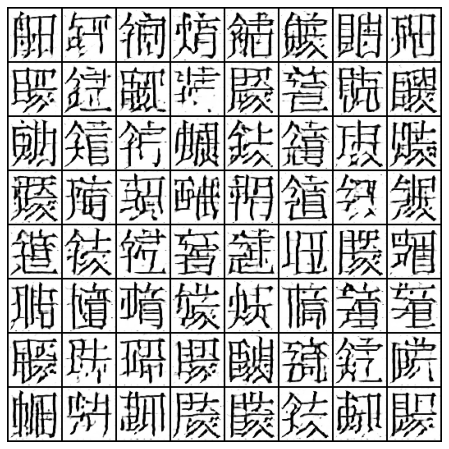

In [107]:
trial_noise = torch.randn(64, 100,1,1)
with torch.no_grad():
                trial_fake = G(trial_noise).detach()
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(np.transpose(vutils.make_grid(trial_fake, padding=2, normalize=True),(1,2,0)))
plt.show()

In [179]:
# to enhane G outputs.
from skimage.restoration import denoise_tv_chambolle
from skimage import data, img_as_float

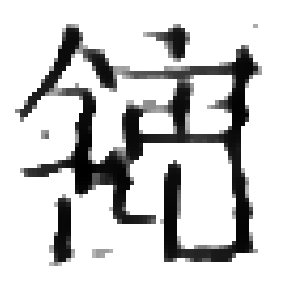

In [188]:
# animation
ani_noise_1 = torch.randn(1, 100, 1, 1)
N = 200
ani_list = []

for k in range(5):
    ani_noise_2 = torch.randn(1, 100, 1, 1)
    for i in range(N):
        with torch.no_grad():
                ani_fake = G3((N-i)/N*ani_noise_1 + i/N*ani_noise_2).detach()
        ani_list.append(ani_fake)
    ani_noise_1 = ani_noise_2

np_ani_list = np.array([denoise_tv_chambolle(img_as_float(np.array(i[0][0])), weight=0.4) for i in ani_list])
#np_ani_list[np_ani_list < 0.5] = 0
np_ani_list[np_ani_list > 0.5] = 1
ani_fig = plt.figure(figsize=(5,5))
plt.axis("off")
ims = [[plt.imshow(i, animated=True, cmap='gray')] for i in np_ani_list]
ani = animation.ArtistAnimation(ani_fig, ims, interval=30, repeat_delay=1000, blit=True)
#HTML(ani.to_jshtml())
HTML(ani.to_html5_video())